## Equivalencia entre haces de radiación cuadrados y rectangulares

Para esteblecer qué campo cuadrado es equivalente a un campo rectangular dado se emplea una relación empírica que establece que ambos deben tener la mima relación área perímetro.

En este notebook se simulan haces de un acelerador lineal que atraviesan un cilindro de agua a lo largo del eje. Los haces son rectangulares con diferente relación ancho/largo. Se registra la fluencia en varios puntos a lo largo del eje y se calcula el Kerma en profundidad. Para comprobar la relación empírica de equivalencia basada en la misma relación área perímetro se compara el Kerma de campos rectangulares que guardan esa relación.

Para un campo rectangular de lados $a$ y $b$ la relación área perímetro $R$ viene dada por
\begin{equation}
  R = \frac{a\, b}{2\, (a+b)}.
\end{equation}

Despejando $b$ obtenemos el valor del alto para un valor dado de $R$ y un ancho de campo $a$:
\begin{equation}
  b = \frac{2\, a\, R}{a - 2\, R}.
\end{equation}

Definimos esta función

In [1]:
def bf(R, a):
  return 2*a*R/(a-2*R)

Calcular un rango de campos rectangulares para $R = 2.5$ que corresponde a la relación área perímetro del campo cuadrado de 10x10

In [2]:
R_field = 2.5
as_field = [10.0, 12.5, 15.0, 17.5, 20.0]
bs_field = [bf(R_field, a_field) for a_field in as_field]
as_field, bs_field

([10.0, 12.5, 15.0, 17.5, 20.0],
 [10.0, 8.333333333333334, 7.5, 7.0, 6.666666666666667])

In [3]:
!git clone https://github.com/JaimeRosado/LegPy

Cloning into 'LegPy'...
remote: Enumerating objects: 1110, done.
remote: Counting objects: 100% (561/561), done.
remote: Compressing objects: 100% (503/503), done.
remote: Total 1110 (delta 137), reused 465 (delta 57), pack-reused 549 (from 1)
Receiving objects: 100% (1110/1110), 2.75 MiB | 9.73 MiB/s, done.
Resolving deltas: 100% (293/293), done.


In [4]:
import sys
sys.path.append('/content/LegPy')

In [5]:
import LegPy as lpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%pip -q install xlsxwriter
import xlsxwriter
from tqdm.notebook import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 2.3 MB/s eta 0:00:00


#### Datos para la simulación

In [6]:
cyl_length = 40. # cm longitud (altura) del cilindro
cyl_diam = 30. # cm diámetro del cilindro

Rf = 100. # cm distancia focal
nz = 40 # número de posiciones en el eje z para evaluar la fluencia y el Kerma (más z=0)
nr = 6 # radial intervals. La fluencia se calcula a lo largo del eje en circulos de radio cyl_diam / nr
nE = 80 # número de energías para la fluencia espectral

Comprobar las dimensiones de los campos dentro de la geometría de cálculo

In [7]:
for a_field, b_field in zip(as_field, bs_field):
  if cyl_diam/nr > a_field:
      print('Error para a=', a_field, ': El bin central debe quedar integramente dentro del haz (cyl_diam/nr < a_field). De otro modo el análisis no es válido.')
  if cyl_diam/nr > b_field:
      print('Error para b=', b_field, ': El bin central debe quedar integramente dentro del haz (cyl_diam/nr < b_field). De otro modo el análisis no es válido.')

### Datos para el análisis

In [8]:
density = 1.0 # densidad del medio
as_field_m = [a_field / 100. for a_field in as_field] # en metros
bs_field_m = [b_field / 100. for b_field in bs_field] # en metros
flus_inp = [1./ (a_field_m) / (b_field_m) for a_field_m, b_field_m in zip(as_field_m, bs_field_m)] # fluencia (1/m^2) por fotón simulado.
print('fluences (1/m^2) per simulated photon =', flus_inp)

fluences (1/m^2) per simulated photon = [100.0, 95.99999999999999, 88.8888888888889, 81.63265306122449, 75.0]


#### Nombres de los ficheros que hay que usar

In [9]:
# espectro de 6MV usado en la simulación.
spect_file = 'LegPy/LegPy/beam_spectra/6MV'

# coeficientes de atenuación (cm^2/g) para agua usados en la simulación (NIST) (fotel., Incoh. Coher, par)
mu_w_file = 'LegPy/LegPy/xsection_data/Water.txt'#

# coeficientes de atenuación y absorción (cm^2/g) para agua tambien de NIST.
abs_at_file = '/content/LegPy/LegPy/photon_data/Water, Liquid.txt'

In [10]:
spect = np.loadtxt(spect_file + '.txt')
nE_b = spect.shape[0]

### Simulación de campos rectangulares

#### Construcción de los objetos: Medium, Geometry, Spectrum, Beam

In [11]:
medium = lpy.Medium(name='Water, Liquid') # otros medios: 'Tissue', 'Bone', 'Muscle'
geometry = lpy.Geometry(name='cylinder', z = cyl_length, diam = cyl_diam, n_r = nr, n_z = 1)
spectrum = lpy.Spectrum(name = 'from_file', file = spect_file)
beams = [lpy.Beam(name = 'isotropic', x_ap = a_field, y_ap = b_field, p_in = np.array ([0., 0., -Rf])) for a_field, b_field in zip(as_field, bs_field)]
#beam = lpy.Beam(name = 'isotropic', diam = d_field, p_in = np.array ([0., 0., -Rf]))

Representar el espectro de energía del haz

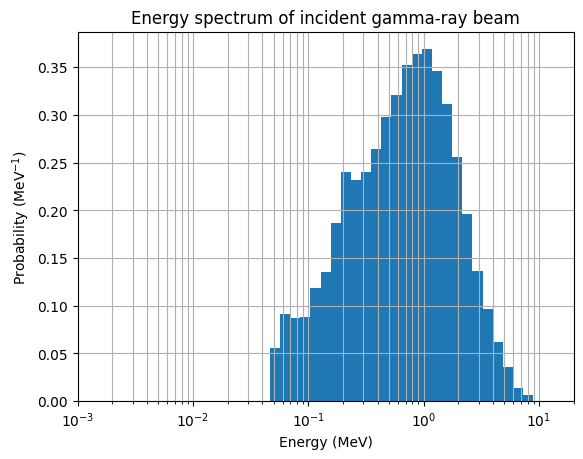

In [12]:
spectrum.plot(n_part = 100000, n_bin = 50)

Visualizar algunas trazas

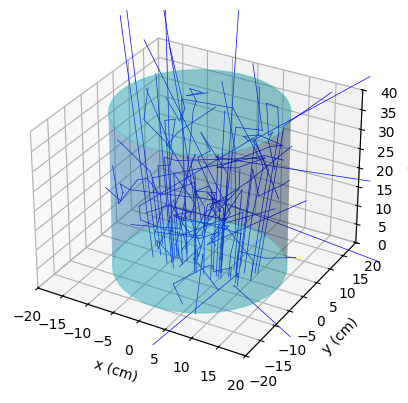

In [13]:
lpy.Plot_beam(medium, geometry, spectrum, beams[4])

### Realizar la simulación

In [14]:
outputs = [lpy.MC(medium, geometry, spectrum, beam, n_part = 100000, n_E = nE) for beam in tqdm(beams)]

  0%|          | 0/5 [00:00<?, ?it/s]


The simulation has ended

Computing time per beam particle =  7.06e-04 seconds


The simulation has ended

Computing time per beam particle =  5.35e-04 seconds


The simulation has ended

Computing time per beam particle =  5.28e-04 seconds


The simulation has ended

Computing time per beam particle =  5.29e-04 seconds


The simulation has ended

Computing time per beam particle =  5.14e-04 seconds



#### Determinación del Kerma para cada campo

In [15]:
Emu = np.loadtxt(abs_at_file)

# usando la lista mu_en(cm^2/g) de la table data (NIST) se genera una lista ampliada por interpolación lineal en
#una escala logarítmica
log_energy = np.log10(Emu[:,0])
log_mu_en = np.log10(Emu[:,2])
#
E1 = 1.e-3
E2 = 20.
log_en_list = np.linspace(np.log10(E1), np.log10(E2), num = 150)
energy = 10.**log_en_list
#
log_mu_en_int = np.interp(log_en_list, log_energy, log_mu_en)
mu_en = 10.**log_mu_en_int
mu_en = mu_en * 0.1 # en m^2/kg

In [16]:
K_df = pd.DataFrame()
for a_field, b_field, output, flu_inp in zip(as_field, bs_field, outputs, flus_inp):
  flu_df = output.fluence_to_df()
  flu_mc = flu_df[1:].copy(deep=True) # fluencia espectral por foton simulado.
  flu_mc = flu_mc / flu_inp # f.e. por unidad de fluencia entrante en el voxel central (1 ph/m^2)
  depth_mc = flu_mc.index.values.astype('float64') # astype -> float values
  K_df['depth'] = depth_mc
  energy_mc = flu_mc.columns.values[0:-1].astype('float64') # borrra la ultima columna (total fluence) y -> float 64
  nz_fl = len(depth_mc) # número de profundidades (planos) para fluencia en el MC
  delta_Emc = energy_mc[1] - energy_mc[0]
  spflu_mc = flu_mc.values[:, :-1] # borra la ultima columna (total fluence)
  nE_mc = spflu_mc.shape[1]

  #### Kerma en profundidad a partir de la fluencia espectral
  # El Kerma se calcula a partir de la fluencia simulada sobre el eje en círculos de radio igual al radio del voxel central.
  K_fl = np.empty_like(depth_mc)

  e_min = energy_mc.min() # limite inferior de integración
  e_max = energy_mc.max() # límite superior

  mu_en_f = np.stack((energy, mu_en), axis = 1)
  for i in range(nz_fl): # at depths of the fluence dataframe
      ExF = np.stack((energy_mc, energy_mc * spflu_mc[i]), axis = 1)
      K_fl[i] = lpy.int_pro(ExF, mu_en_f, e_min, e_max)
  K_df[str(a_field)+'x'+'{:2.1f}'.format(b_field)] = K_fl

# Añadir las columnas con las fluencias renormalizadas a profundidad 0
for col in K_df.columns[2:]:
  K_df['n ' + col] = K_df[col] / K_df['10.0x10.0']

K_df

<ipython-input-16-0b53b90df155>:4: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  flu_mc = flu_df[1:].copy(deep=True) # fluencia espectral por foton simulado.
<ipython-input-16-0b53b90df155>:4: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  flu_mc = flu_df[1:].copy(deep=True) # fluencia espectral por foton simulado.
<ipython-input-16-0b53b90df155>:4: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  flu_mc = flu_df[1:].copy(deep=True) # fluencia espectral por foton simulado.
<ipython-input-16-0b53b90df1

,depth,10.0x10.0,12.5x8.3,15.0x7.5,17.5x7.0,20.0x6.7,n 12.5x8.3,n 15.0x7.5,n 17.5x7.0,n 20.0x6.7
0,2.0,0.610208,0.608766,0.611329,0.618422,0.608293,0.997636,1.001836,1.013460,0.996860
1,4.0,0.553857,0.559831,0.552079,0.560830,0.549522,1.010786,0.996789,1.012589,0.992173
2,6.0,0.501353,0.509638,0.499843,0.510357,0.499313,1.016526,0.996989,1.017961,0.995932
3,8.0,0.456141,0.465493,0.454477,0.459749,0.450806,1.020504,0.996352,1.007911,0.988304
4,10.0,0.418415,0.421719,0.412031,0.417043,0.409528,1.007899,0.984743,0.996721,0.978762
5,12.0,0.379498,0.380914,0.372012,0.378040,0.369307,1.003731,0.980272,0.996157,0.973145
6,14.0,0.343561,0.344233,0.333769,0.343928,0.336537,1.001956,0.971498,1.001069,0.979556
7,16.0,0.312338,0.310641,0.303406,0.308876,0.304350,0.994566,0.971402,0.988915,0.974424
8,18.0,0.282270,0.280473,0.273877,0.279617,0.275137,0.993632,0.970265,0.990600,0.974729
9,20.0,0.255711,0.253915,0.248663,0.252687,0.249122,0.992979,0.972437,0.988174,0.974234


#### Plot de Kerma vs z

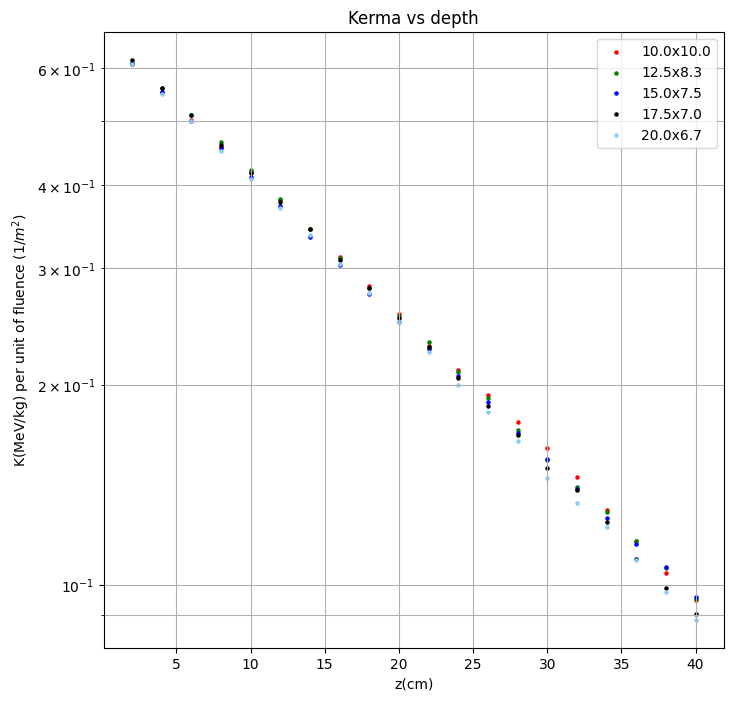

In [20]:
fig, ax = plt.subplots(figsize = (8,8))
colors=['r', 'g', 'b', 'k', 'lightskyblue']
[K_df.plot.scatter(x='depth', y=field, ax=ax, label=field, marker='.', c=color) for field, color in zip(K_df.columns[1:6], colors)]
ax.grid(True, which='both')
ax.set_yscale('log')
ax.set_xlabel('z(cm)')
ax.set_ylabel(r'K(MeV/kg) per unit of fluence $(1/m^2)$')
ax.set_title('Kerma vs depth')
plt.show()

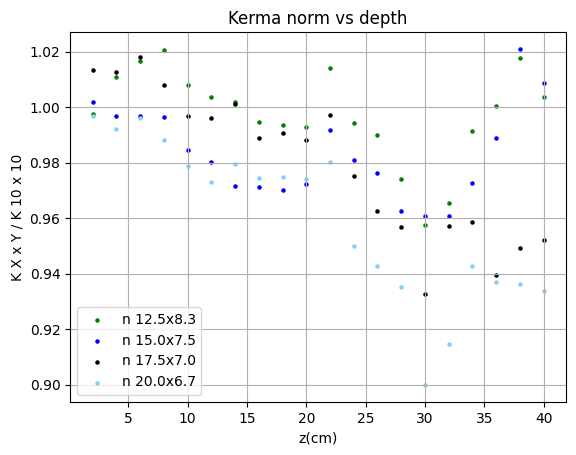

In [18]:
fig, ax = plt.subplots()
colors=['g', 'b', 'k', 'lightskyblue']
[K_df.plot.scatter(x='depth', y=field, ax=ax, label=field, marker='.', c=color) for field, color in zip(K_df.columns[-4:], colors)]
ax.grid(True, which='both')
ax.set_xlabel('z(cm)')
ax.set_ylabel(r'K X x Y / K 10 x 10')
ax.set_title('Kerma norm vs depth')
plt.show()

Con una incertidumbre del orden del 1% o el 2% todos los campos producen el mismo kerma independientemente de la profundidad, por lo que resultan ser equivalentes.